In [13]:
import pandas as pd

df = pd.read_csv("../data/df_indi_works.csv", index_col=0)
regions = pd.read_csv('ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)

,individual_wikidata_id,cultural_score,birthyear,decade,individual_name,region_code,region_name,century
2,Q100035,2.0,1800.0,1800,Franz von Gaudy,re_german_world,German world,1800
6,Q1000899,1.0,1840.0,1840,Leó Fessler,re_german_world,German world,1800
8,Q1001063,2.0,1848.0,1850,Olga Fialka,re_eastern_europe,Eastern Europe,1800
9,Q1001063,2.0,1848.0,1850,Olga Fialka,re_central_europe,Central Europe,1800
12,Q100116,2.0,1654.0,1650,Christoph Weigel the Elder,re_german_world,German world,1600
16,Q100156894,1.0,1817.0,1820,Jacob Christian Gottschalk,re_nordic_countries,Nordic countries,1800
20,Q100242,16.0,1775.0,1780,Johann Jakob Dorner the Younger,re_german_world,German world,1800
24,Q100252598,2.0,1795.0,1800,Alexis Durand,re_france,France,1800
28,Q100269025,1.0,1849.0,1850,Giovanni Avolio,re_italy,Italy,1800
32,Q100277,1.0,1843.0,1840,Moritz Fleischer,re_german_world,German world,1800


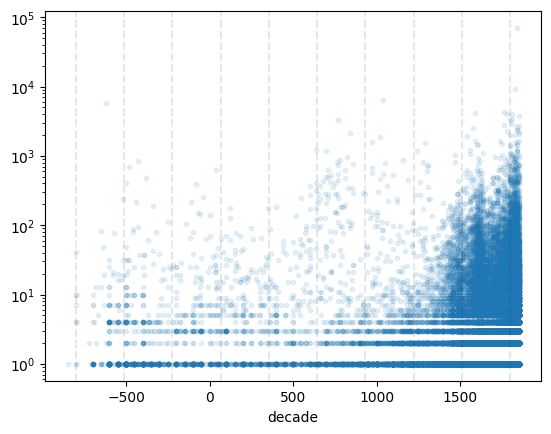

In [42]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)

fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["cultural_score"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [54]:
df['count'] = df['cultural_score']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})]
df_m['y'] = df_m['count'].map({0:0, 1: 0, 2: 1})
df_m.sample(10)

,individual_wikidata_id,cultural_score,birthyear,decade,individual_name,region_code,region_name,century,count,y
424184,Q61052114,0.0,1838.0,1840,Simon Gaberc,re_eastern_europe,Eastern Europe,1800,0.0,0
425227,Q2831583,0.0,1839.0,1840,Albert Tissandier,re_france,France,1800,0.0,0
237593,Q55126766,0.0,1770.0,1770,Franz Ignaz Thanner,re_german_world,German world,1800,0.0,0
253197,Q15071919,0.0,1845.0,1840,Sofya Alexandrovna Malozyomova,re_slav_world,Slav world,1800,0.0,0
363935,Q1681834,0.0,1486.0,1490,Johann Apel,re_german_world,German world,1500,0.0,0
85145,Q3719677,1.0,1838.0,1840,Edoardo Tofano,re_italy,Italy,1800,1.0,0
284040,Q2910594,0.0,1731.0,1730,Thomas Postlethwaite,re_united_kingdom,United Kingdom,1700,0.0,0
529527,Q95252732,0.0,1802.0,1800,Martin Mayer,re_german_world,German world,1800,0.0,0
528788,Q3770119,0.0,1801.0,1800,Giuseppe Bianca,re_italy,Italy,1800,0.0,0
466135,Q2574255,0.0,1819.0,1820,Wilhelm Molitor,re_german_world,German world,1800,0.0,0


In [95]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

sample = df_m#.sample(10_000)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
}

m_splines = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True)', sample, family='bernoulli', priors=priors)
m_splines

       Formula: y ~ bs(decade, knots=iknots, intercept=True)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots = iknots, intercept = True) ~ Normal(mu: 0.0, sigma: 5.0)

In [96]:
p_splines = m_splines.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots = iknots, intercept = True)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2666 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.527,1.480,-5.104,0.365,0.067,0.047,490.0,563.0,1.01
"bs(decade, knots = iknots, intercept = True)[0]",0.255,1.840,-3.353,3.444,0.072,0.051,651.0,988.0,1.01
"bs(decade, knots = iknots, intercept = True)[1]",1.226,1.623,-1.821,4.212,0.068,0.048,574.0,864.0,1.00
"bs(decade, knots = iknots, intercept = True)[2]",-1.114,1.562,-4.110,1.676,0.067,0.049,537.0,723.0,1.00
"bs(decade, knots = iknots, intercept = True)[3]",-0.268,1.519,-3.193,2.446,0.067,0.047,516.0,659.0,1.00
"bs(decade, knots = iknots, intercept = True)[4]",0.187,1.523,-2.630,3.026,0.068,0.048,507.0,647.0,1.01
"bs(decade, knots = iknots, intercept = True)[5]",0.888,1.513,-2.000,3.579,0.067,0.047,516.0,656.0,1.01
"bs(decade, knots = iknots, intercept = True)[6]",-0.058,1.509,-2.967,2.669,0.067,0.047,507.0,606.0,1.01
"bs(decade, knots = iknots, intercept = True)[7]",0.085,1.511,-2.826,2.748,0.067,0.047,508.0,603.0,1.01
"bs(decade, knots = iknots, intercept = True)[8]",0.143,1.487,-2.759,2.771,0.067,0.047,495.0,549.0,1.01


In [135]:
def plot_predictions(data, idata, model, region=None, ax=None, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked =  az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

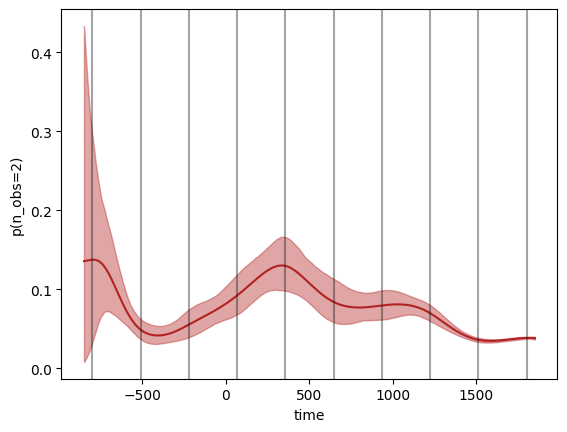

In [100]:
plot_predictions(sample, p_splines, m_splines);

In [130]:
sample = df_m#.sample(10_000)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

       Formula: y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots = iknots, intercept = True) ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.0))

In [131]:
p_splines_vi = m_splines_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines_vi)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots = iknots, intercept = True), 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4607 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.522,1.454,-5.254,0.190,0.054,0.039,719.0,1168.0,1.01
"bs(decade, knots = iknots, intercept = True)[0]",0.544,1.812,-3.072,3.676,0.056,0.040,1043.0,1803.0,1.00
"bs(decade, knots = iknots, intercept = True)[1]",1.507,1.619,-1.381,4.624,0.056,0.040,824.0,1405.0,1.01
"bs(decade, knots = iknots, intercept = True)[2]",-0.829,1.512,-3.575,2.081,0.055,0.039,766.0,1296.0,1.01
"bs(decade, knots = iknots, intercept = True)[3]",-0.073,1.515,-2.799,2.844,0.055,0.039,766.0,1367.0,1.01
"bs(decade, knots = iknots, intercept = True)[4]",0.202,1.485,-2.602,2.919,0.055,0.039,746.0,1297.0,1.01
"bs(decade, knots = iknots, intercept = True)[5]",0.889,1.497,-1.933,3.606,0.055,0.039,734.0,1319.0,1.01
"bs(decade, knots = iknots, intercept = True)[6]",-0.070,1.490,-2.861,2.677,0.054,0.038,759.0,1314.0,1.01
"bs(decade, knots = iknots, intercept = True)[7]",-0.044,1.482,-2.640,2.829,0.055,0.039,726.0,1302.0,1.01
"bs(decade, knots = iknots, intercept = True)[8]",0.032,1.462,-2.845,2.590,0.055,0.039,721.0,1171.0,1.01


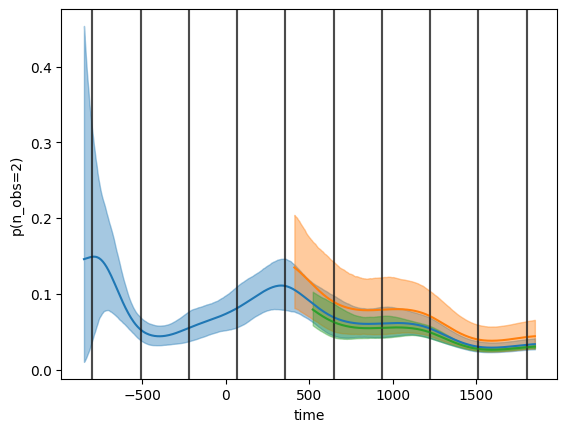

In [138]:
fig, ax = plt.subplots()
plot_predictions(sample, p_splines_vi, m_splines_vi, "Greek World", ax=ax, color="C0");
plot_predictions(sample, p_splines_vi, m_splines_vi, "Korea", ax=ax, color="C1");
plot_predictions(sample, p_splines_vi, m_splines_vi, "German world", ax=ax, color="C2");

In [145]:
sample = df_m#.sample(10_000)

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "bs(decade, knots=iknots, intercept=True)|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

       Formula: y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 161649
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            bs(decade, knots = iknots, intercept = True)|region_name ~ Normal(mu: 0.0, sigma:
                HalfNormal(sigma: [322.5098  95.0733  49.3273  50.422   61.3134  70.5917  72.4735  48.3015
              24.794   13.8189  13.1734   7.2596]))